## Imports & Initialization

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, lit, trim, to_timestamp, unix_timestamp,
    hour, dayofweek, month, date_format,
    radians, sin, cos, asin, sqrt,
    monotonically_increasing_id, broadcast,
    avg, count
)
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import warnings
warnings.filterwarnings("ignore")

print(" All imports loaded successfully!")


 All imports loaded successfully!


## STEP 1: Start Spark + Load CSVs

In [2]:

# STEP 1: DATA INGESTION (LOAD BOTH CSV FILES)
print("\n" + "="*80)
print("STEP 1: DATA INGESTION (SIRI + TIMETABLE)")
print("="*80)

spark = SparkSession.builder \
    .appName("BusAnalytics_SIRI_Timetable") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

SIRI_PATH = "siri.csv"
TIMETABLE_PATH = "bus_data_combined.csv"

df_siri_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(SIRI_PATH)
df_tt_raw   = spark.read.option("header", "true").option("inferSchema", "true").csv(TIMETABLE_PATH)

print(f" SIRI records: {df_siri_raw.count():,} | columns: {len(df_siri_raw.columns)}")
print(f"Timetable stop records: {df_tt_raw.count():,} | columns: {len(df_tt_raw.columns)}")

print("\nSIRI Schema:")
df_siri_raw.printSchema()

print("\nTimetable Schema:")
df_tt_raw.printSchema()

print("\nSIRI sample:")
df_siri_raw.show(5, truncate=False)

print("\nTimetable sample:")
df_tt_raw.show(5, truncate=False)



STEP 1: DATA INGESTION (SIRI + TIMETABLE)
 SIRI records: 27,829 | columns: 27
Timetable stop records: 428 | columns: 5

SIRI Schema:
root
 |-- RecordedAtTime: timestamp (nullable = true)
 |-- ItemIdentifier: string (nullable = true)
 |-- ValidUntilTime: timestamp (nullable = true)
 |-- MonitoredVehicleJourney/LineRef: string (nullable = true)
 |-- MonitoredVehicleJourney/DirectionRef: string (nullable = true)
 |-- MonitoredVehicleJourney/FramedVehicleJourneyRef/DataFrameRef: date (nullable = true)
 |-- MonitoredVehicleJourney/FramedVehicleJourneyRef/DatedVehicleJourneyRef: string (nullable = true)
 |-- MonitoredVehicleJourney/PublishedLineName: string (nullable = true)
 |-- MonitoredVehicleJourney/OperatorRef: string (nullable = true)
 |-- MonitoredVehicleJourney/OriginRef: string (nullable = true)
 |-- MonitoredVehicleJourney/OriginName: string (nullable = true)
 |-- MonitoredVehicleJourney/DestinationRef: string (nullable = true)
 |-- MonitoredVehicleJourney/DestinationName: string 

## STEP 2: Cleaning (Trim + Fix datatypes)

In [3]:
# STEP 2: DATA CLEANING
print("\n" + "="*80)
print("STEP 2: DATA CLEANING")
print("="*80)

# --- Trim all string columns (SIRI) ---
df_siri = df_siri_raw
for c in df_siri.columns:
    df_siri = df_siri.withColumn(c, trim(col(c).cast("string")))

# --- Trim all string columns (Timetable) ---
df_tt = df_tt_raw
for c in df_tt.columns:
    df_tt = df_tt.withColumn(c, trim(col(c).cast("string")))

# Convert lat/lon to double (SIRI)
df_siri = df_siri.withColumn("lat", col("MonitoredVehicleJourney/VehicleLocation/Latitude").cast("double")) \
                 .withColumn("lon", col("MonitoredVehicleJourney/VehicleLocation/Longitude").cast("double"))

# Convert lat/lon to double (timetable)
df_tt = df_tt.withColumn("stop_lat", col("AnnotatedStopPointRef_Location_Latitude").cast("double")) \
             .withColumn("stop_lon", col("AnnotatedStopPointRef_Location_Longitude").cast("double"))

# Drop rows missing location
before = df_siri.count()
df_siri = df_siri.filter(col("lat").isNotNull() & col("lon").isNotNull())
after = df_siri.count()
print(f"Removed {before-after:,} SIRI rows with missing GPS")

# Parse timestamps (SIRI)
df_siri = df_siri.withColumn("RecordedAtTime_ts", to_timestamp(col("RecordedAtTime"))) \
                 .withColumn("OriginAimedDepartureTime_ts", to_timestamp(col("MonitoredVehicleJourney/OriginAimedDepartureTime"))) \
                 .withColumn("ValidUntilTime_ts", to_timestamp(col("ValidUntilTime")))

print(f"Clean SIRI rows: {df_siri.count():,}")
print(f" Clean Timetable rows: {df_tt.count():,}")

df_siri.select("RecordedAtTime", "RecordedAtTime_ts", "lat", "lon").show(5, truncate=False)



STEP 2: DATA CLEANING
Removed 0 SIRI rows with missing GPS
Clean SIRI rows: 27,829
 Clean Timetable rows: 428
+-------------------+-------------------+---------+---------+
|RecordedAtTime     |RecordedAtTime_ts  |lat      |lon      |
+-------------------+-------------------+---------+---------+
|2026-02-07 12:26:56|2026-02-07 12:26:56|52.073873|0.008363 |
|2026-02-07 00:24:55|2026-02-07 00:24:55|52.240808|0.275877 |
|2026-02-07 13:04:46|2026-02-07 13:04:46|52.456401|0.304343 |
|2026-02-06 23:02:05|2026-02-06 23:02:05|52.08629 |0.009121 |
|2026-02-06 23:55:52|2026-02-06 23:55:52|52.123135|-0.266931|
+-------------------+-------------------+---------+---------+
only showing top 5 rows



## STEP 3: Feature Engineering (Delay label from real data)

In [4]:
# STEP 3: FEATURE ENGINEERING (REAL DELAY FROM SIRI)
print("\n" + "="*80)
print("STEP 3: FEATURE ENGINEERING")
print("="*80)

# Delay in minutes = RecordedAtTime - OriginAimedDepartureTime
df_siri = df_siri.withColumn(
    "delay_minutes",
    (unix_timestamp(col("RecordedAtTime_ts")) - unix_timestamp(col("OriginAimedDepartureTime_ts"))) / 60.0
)

# Clean delay values (remove null / extreme wrong)
df_siri = df_siri.filter(col("delay_minutes").isNotNull())
df_siri = df_siri.filter((col("delay_minutes") >= -60) & (col("delay_minutes") <= 240))

# Binary target: delayed if > 5 minutes
df_siri = df_siri.withColumn("is_delayed", when(col("delay_minutes") > 5, 1).otherwise(0))

# Time features
df_siri = df_siri.withColumn("hour_of_day", hour(col("RecordedAtTime_ts"))) \
                 .withColumn("day_of_week", dayofweek(col("RecordedAtTime_ts"))) \
                 .withColumn("month", month(col("RecordedAtTime_ts"))) \
                 .withColumn("is_peak_hour", when((col("hour_of_day").between(7,9)) | (col("hour_of_day").between(17,19)), 1).otherwise(0)) \
                 .withColumn("is_weekend", when(col("day_of_week").isin([1,7]), 1).otherwise(0))

print("Created target label and time features")
df_siri.select("RecordedAtTime_ts", "OriginAimedDepartureTime_ts", "delay_minutes", "is_delayed", "hour_of_day", "is_peak_hour").show(10, truncate=False)



STEP 3: FEATURE ENGINEERING
Created target label and time features
+-------------------+---------------------------+------------------+----------+-----------+------------+
|RecordedAtTime_ts  |OriginAimedDepartureTime_ts|delay_minutes     |is_delayed|hour_of_day|is_peak_hour|
+-------------------+---------------------------+------------------+----------+-----------+------------+
|2026-02-07 00:24:55|2026-02-07 00:00:00        |24.916666666666668|1         |0          |0           |
|2026-02-07 13:04:46|2026-02-07 12:20:00        |44.766666666666666|1         |13         |0           |
|2026-02-06 23:02:05|2026-02-06 22:15:00        |47.083333333333336|1         |23         |0           |
|2026-02-06 23:55:52|2026-02-06 23:00:00        |55.86666666666667 |1         |23         |0           |
|2026-02-07 13:02:22|2026-02-07 12:30:00        |32.36666666666667 |1         |13         |0           |
|2026-02-06 22:00:26|2026-02-06 21:33:00        |27.433333333333334|1         |22         |0

### Delay vs On-Time (Bar Chart)

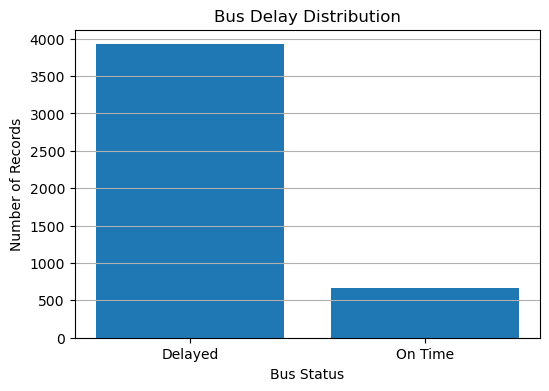

In [13]:
delay_counts = (
    gbt_pred
    .groupBy("is_delayed")
    .count()
    .toPandas()
)

delay_counts["Status"] = delay_counts["is_delayed"].map({0: "On Time", 1: "Delayed"})

plt.figure(figsize=(6,4))
plt.bar(delay_counts["Status"], delay_counts["count"])
plt.title("Bus Delay Distribution")
plt.xlabel("Bus Status")
plt.ylabel("Number of Records")
plt.grid(axis="y")
plt.show()


## STEP 4: Match each SIRI GPS point to nearest timetable stop (Haversine)

In [ ]:
# ============================================================================
# STEP 4: GPS → NEAREST STOP MATCHING (SIRI ↔ Timetable)
# ============================================================================

print("\n" + "="*80)
print("STEP 4: NEAREST STOP MATCHING (HAVERSINE)")
print("="*80)

# Keep timetable stops unique (important)
df_stops = df_tt.select(
    col("AnnotatedStopPointRef_StopPointRef").alias("stop_id"),
    col("AnnotatedStopPointRef_CommonName").alias("stop_name"),
    col("source_file").alias("route_source"),
    col("stop_lat"),
    col("stop_lon")
).dropna(subset=["stop_lat", "stop_lon"]).dropDuplicates(["stop_id", "stop_lat", "stop_lon"])

print(f"Unique stops: {df_stops.count():,}")

# Add unique row id to each SIRI record (so we can window by it after cross join)
df_siri_id = df_siri.withColumn("siri_row_id", monotonically_increasing_id())

# --- HAVERSINE distance (meters) using Spark expressions ---
# distance = 2R * asin( sqrt( sin²((lat2-lat1)/2) + cos(lat1)cos(lat2)sin²((lon2-lon1)/2) ) )
R = 6371000.0  # Earth radius in meters

df_cross = df_siri_id.select("siri_row_id", "lat", "lon", "delay_minutes", "is_delayed",
                             "hour_of_day", "day_of_week", "month", "is_peak_hour", "is_weekend",
                             col("MonitoredVehicleJourney/LineRef").alias("line_ref"),
                             col("MonitoredVehicleJourney/DirectionRef").alias("direction_ref"),
                             col("MonitoredVehicleJourney/OperatorRef").alias("operator_ref"),
                             col("MonitoredVehicleJourney/Bearing").alias("bearing"),
                             col("MonitoredVehicleJourney/Occupancy").alias("occupancy")
                            ) \
    .crossJoin(broadcast(df_stops))

df_cross = df_cross.withColumn("lat1", radians(col("lat"))) \
                   .withColumn("lon1", radians(col("lon"))) \
                   .withColumn("lat2", radians(col("stop_lat"))) \
                   .withColumn("lon2", radians(col("stop_lon")))

df_cross = df_cross.withColumn("dlat", col("lat2") - col("lat1")) \
                   .withColumn("dlon", col("lon2") - col("lon1"))

df_cross = df_cross.withColumn(
    "a",
    (sin(col("dlat")/2)**2) + cos(col("lat1")) * cos(col("lat2")) * (sin(col("dlon")/2)**2)
)

df_cross = df_cross.withColumn("c", 2 * asin(sqrt(col("a"))))
df_cross = df_cross.withColumn("distance_m", lit(R) * col("c"))

# pick nearest stop per SIRI row
w = Window.partitionBy("siri_row_id").orderBy(col("distance_m").asc())
df_nearest = df_cross.withColumn("rn", row_number().over(w)).filter(col("rn") == 1).drop("rn")

print("Matched each SIRI point to nearest timetable stop")
df_nearest.select("siri_row_id", "stop_id", "stop_name", "distance_m", "delay_minutes", "is_delayed").show(10, truncate=False)



STEP 4: NEAREST STOP MATCHING (HAVERSINE)
Unique stops: 273
Matched each SIRI point to nearest timetable stop
+-----------+----------+-------------+------------------+------------------+----------+
|siri_row_id|stop_id   |stop_name    |distance_m        |delay_minutes     |is_delayed|
+-----------+----------+-------------+------------------+------------------+----------+
|0          |490012681N|Rosemont Road|89638.92119583944 |24.916666666666668|1         |
|1          |490012681N|Rosemont Road|112485.64895376205|44.766666666666666|1         |
|2          |490012681N|Rosemont Road|67023.40933327899 |47.083333333333336|1         |
|3          |490012681N|Rosemont Road|68253.15264299359 |55.86666666666667 |1         |
|4          |490012681N|Rosemont Road|89657.23460763012 |32.36666666666667 |1         |
|5          |490012681N|Rosemont Road|52719.940683763285|27.433333333333334|1         |
|6          |490012681N|Rosemont Road|100586.55004446558|44.733333333333334|1         |
|7       

## Average Delay by Hour (Peak Hour Insight)

In [ ]:


from pyspark.sql.functions import (
    col, lit, radians, sin, cos, asin, sqrt,
    monotonically_increasing_id, broadcast
)
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

print("\n" + "="*80)
print("REBUILD STEP 4: CREATING df_nearest")
print("="*80)

# 1) Build stops table from timetable
df_stops = df_tt.select(
    col("AnnotatedStopPointRef_StopPointRef").alias("stop_id"),
    col("AnnotatedStopPointRef_CommonName").alias("stop_name"),
    col("stop_lat").cast("double"),
    col("stop_lon").cast("double")
).dropna(subset=["stop_lat", "stop_lon"]).dropDuplicates(["stop_id", "stop_lat", "stop_lon"])

print("Stops:", df_stops.count())

# 2) Add unique id to siri rows
df_siri_id = df_siri.withColumn("siri_row_id", monotonically_increasing_id())

# 3) Cross join (broadcast stops) + Haversine distance
R = 6371000.0  # meters

df_cross = df_siri_id.select(
    "siri_row_id", "lat", "lon", "delay_minutes", "is_delayed",
    "hour_of_day", "day_of_week", "month", "is_peak_hour", "is_weekend",
    col("MonitoredVehicleJourney/LineRef").alias("line_ref"),
    col("MonitoredVehicleJourney/DirectionRef").alias("direction_ref"),
    col("MonitoredVehicleJourney/OperatorRef").alias("operator_ref"),
    col("MonitoredVehicleJourney/Bearing").alias("bearing"),
    col("MonitoredVehicleJourney/Occupancy").alias("occupancy")
).crossJoin(broadcast(df_stops))

df_cross = (
    df_cross
    .withColumn("lat1", radians(col("lat")))
    .withColumn("lon1", radians(col("lon")))
    .withColumn("lat2", radians(col("stop_lat")))
    .withColumn("lon2", radians(col("stop_lon")))
    .withColumn("dlat", col("lat2") - col("lat1"))
    .withColumn("dlon", col("lon2") - col("lon1"))
)

df_cross = (
    df_cross
    .withColumn(
        "a",
        (sin(col("dlat")/2)**2) +
        cos(col("lat1")) * cos(col("lat2")) * (sin(col("dlon")/2)**2)
    )
    .withColumn("c", 2 * asin(sqrt(col("a"))))
    .withColumn("distance_m", lit(R) * col("c"))
)

# 4) Pick nearest stop per siri row
w = Window.partitionBy("siri_row_id").orderBy(col("distance_m").asc())
df_nearest = df_cross.withColumn("rn", row_number().over(w)) \
                     .filter(col("rn") == 1) \
                     .drop("rn")

print("✅ df_nearest created. Rows:", df_nearest.count())
df_nearest.select("stop_name", "distance_m", "delay_minutes", "is_delayed").show(5, truncate=False)



REBUILD STEP 4: CREATING df_nearest
✅ Stops: 273
✅ df_nearest created. Rows: 23452
+-------------+------------------+------------------+----------+
|stop_name    |distance_m        |delay_minutes     |is_delayed|
+-------------+------------------+------------------+----------+
|Rosemont Road|89638.92119583944 |24.916666666666668|1         |
|Rosemont Road|112485.64895376205|44.766666666666666|1         |
|Rosemont Road|67023.40933327899 |47.083333333333336|1         |
|Rosemont Road|68253.15264299359 |55.86666666666667 |1         |
|Rosemont Road|89657.23460763012 |32.36666666666667 |1         |
+-------------+------------------+------------------+----------+
only showing top 5 rows



## STEP 5: EDA 


STEP 5: EDA
+----------+-----+
|is_delayed|count|
+----------+-----+
|         1|19934|
|         0| 3518|
+----------+-----+



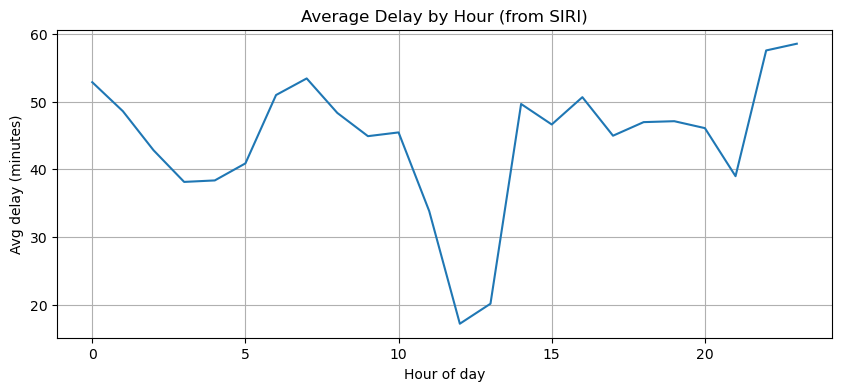

In [ ]:
print("\n" + "="*80)
print("STEP 5: EDA")
print("="*80)

# delayed distribution
df_nearest.groupBy("is_delayed").agg(count("*").alias("count")).show()

# average delay by hour
hour_stats = df_nearest.groupBy("hour_of_day").agg(
    avg("delay_minutes").alias("avg_delay")
).orderBy("hour_of_day")

hour_pd = hour_stats.toPandas()

plt.figure(figsize=(10,4))
plt.plot(hour_pd["hour_of_day"], hour_pd["avg_delay"])
plt.xlabel("Hour of day")
plt.ylabel("Avg delay (minutes)")
plt.title("Average Delay by Hour (from SIRI)")
plt.grid(True)
plt.show()


## STEP 6: Prepare ML Dataset (Index + Assemble + Scale)

In [ ]:
print("\n" + "="*80)
print("STEP 6: ML PREP")
print("="*80)

df_ml = df_nearest

# Convert numeric columns properly
df_ml = df_ml.withColumn("bearing", col("bearing").cast("double")) \
             .withColumn("distance_m", col("distance_m").cast("double"))

# Fill missing categorical values
df_ml = df_ml.fillna({
    "line_ref": "Unknown",
    "direction_ref": "Unknown",
    "operator_ref": "Unknown",
    "occupancy": "Unknown"
})

# Fill missing numeric values
df_ml = df_ml.fillna({
    "bearing": 0.0,
    "distance_m": 0.0
})

# Define categorical + numeric features
cat_cols = ["line_ref", "direction_ref", "operator_ref", "occupancy", "stop_id"]
num_cols = ["distance_m", "bearing", "hour_of_day", "day_of_week", "month", "is_peak_hour", "is_weekend"]

# StringIndexers for categories
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]

# Assemble features
feature_cols = [f"{c}_idx" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

print("✅ Indexers + Assembler + Scaler created")
print("Feature columns:", feature_cols)



STEP 6: ML PREP
✅ Indexers + Assembler + Scaler created
Feature columns: ['line_ref_idx', 'direction_ref_idx', 'operator_ref_idx', 'occupancy_idx', 'stop_id_idx', 'distance_m', 'bearing', 'hour_of_day', 'day_of_week', 'month', 'is_peak_hour', 'is_weekend']


## STEP 7: Train/Test Split + Logistic Regression

In [ ]:
print("\n" + "="*80)
print("STEP 7: TRAINING - LOGISTIC REGRESSION")
print("="*80)

train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_df.count():,} | Test: {test_df.count():,}")

lr = LogisticRegression(featuresCol="features", labelCol="is_delayed", maxIter=50)

lr_pipeline = Pipeline(stages=indexers + [assembler, scaler, lr])
lr_model = lr_pipeline.fit(train_df)

lr_pred = lr_model.transform(test_df)

# Evaluations
bin_eval = BinaryClassificationEvaluator(labelCol="is_delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = bin_eval.evaluate(lr_pred)

multi_eval = MulticlassClassificationEvaluator(labelCol="is_delayed", predictionCol="prediction", metricName="accuracy")
acc = multi_eval.evaluate(lr_pred)

print(f"Logistic Regression AUC: {auc:.4f}")
print(f"Logistic Regression Accuracy: {acc:.4f}")

lr_pred.select("is_delayed", "prediction", "probability", "delay_minutes", "stop_name", "distance_m").show(10, truncate=False)



STEP 7: TRAINING - LOGISTIC REGRESSION
Train: 18,865 | Test: 4,587


## STEP 8: Train a Stronger Mode

In [8]:


from pyspark.sql.functions import radians, sin, cos, asin, sqrt, monotonically_increasing_id, broadcast
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lit

print("\n" + "="*80)
print("STEP 4: NEAREST STOP MATCHING (REBUILD)")
print("="*80)

# ---- Prepare stops ----
df_stops = df_tt.select(
    col("AnnotatedStopPointRef_StopPointRef").alias("stop_id"),
    col("AnnotatedStopPointRef_CommonName").alias("stop_name"),
    col("stop_lat"),
    col("stop_lon")
).dropna(subset=["stop_lat", "stop_lon"]).dropDuplicates(["stop_id", "stop_lat", "stop_lon"])

print("Stops:", df_stops.count())

# ---- Add unique ID to SIRI ----
df_siri_id = df_siri.withColumn("siri_row_id", monotonically_increasing_id())

# ---- Haversine distance ----
R = 6371000.0

df_cross = df_siri_id.select(
    "siri_row_id", "lat", "lon", "delay_minutes", "is_delayed",
    "hour_of_day", "day_of_week", "month", "is_peak_hour", "is_weekend",
    col("MonitoredVehicleJourney/LineRef").alias("line_ref"),
    col("MonitoredVehicleJourney/DirectionRef").alias("direction_ref"),
    col("MonitoredVehicleJourney/OperatorRef").alias("operator_ref"),
    col("MonitoredVehicleJourney/Bearing").alias("bearing"),
    col("MonitoredVehicleJourney/Occupancy").alias("occupancy")
).crossJoin(broadcast(df_stops))

df_cross = (
    df_cross
    .withColumn("lat1", radians(col("lat")))
    .withColumn("lon1", radians(col("lon")))
    .withColumn("lat2", radians(col("stop_lat")))
    .withColumn("lon2", radians(col("stop_lon")))
    .withColumn("dlat", col("lat2") - col("lat1"))
    .withColumn("dlon", col("lon2") - col("lon1"))
)

df_cross = (
    df_cross
    .withColumn(
        "a",
        (sin(col("dlat")/2)**2) +
        cos(col("lat1")) * cos(col("lat2")) * (sin(col("dlon")/2)**2)
    )
    .withColumn("c", 2 * asin(sqrt(col("a"))))
    .withColumn("distance_m", lit(R) * col("c"))
)

# ---- Pick nearest stop ----
w = Window.partitionBy("siri_row_id").orderBy(col("distance_m").asc())
df_nearest = df_cross.withColumn("rn", row_number().over(w)) \
                     .filter(col("rn") == 1) \
                     .drop("rn")

print("✅ df_nearest created:", df_nearest.count())
df_nearest.select("stop_name", "distance_m", "delay_minutes", "is_delayed").show(5)



STEP 4: NEAREST STOP MATCHING (REBUILD)
Stops: 273
✅ df_nearest created: 23452
+-------------+------------------+------------------+----------+
|    stop_name|        distance_m|     delay_minutes|is_delayed|
+-------------+------------------+------------------+----------+
|Rosemont Road| 89638.92119583944|24.916666666666668|         1|
|Rosemont Road|112485.64895376205|44.766666666666666|         1|
|Rosemont Road| 67023.40933327899|47.083333333333336|         1|
|Rosemont Road| 68253.15264299359| 55.86666666666667|         1|
|Rosemont Road| 89657.23460763012| 32.36666666666667|         1|
+-------------+------------------+------------------+----------+
only showing top 5 rows



### MODEL EVALUATION METRICS (Accuracy, Precision, Recall, F1, ROC)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("MODEL EVALUATION METRICS (GBT)")
print("="*80)

# ---------------- Accuracy ----------------
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_delayed",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = accuracy_evaluator.evaluate(gbt_pred)

# ---------------- Precision ----------------
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_delayed",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(gbt_pred)

# ---------------- Recall ----------------
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_delayed",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(gbt_pred)

# ---------------- F1 Score ----------------
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_delayed",
    predictionCol="prediction",
    metricName="f1"
)
f1 = f1_evaluator.evaluate(gbt_pred)

# ---------------- ROC AUC ----------------
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="is_delayed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = roc_evaluator.evaluate(gbt_pred)

# ---------------- Print Metrics ----------------
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}")
print(f"ROC AUC        : {roc_auc:.4f}")



MODEL EVALUATION METRICS (GBT)
Accuracy       : 0.8607
Precision      : 0.8296
Recall         : 0.8607
F1-score       : 0.8287
ROC AUC        : 0.8172


### ROC Curve

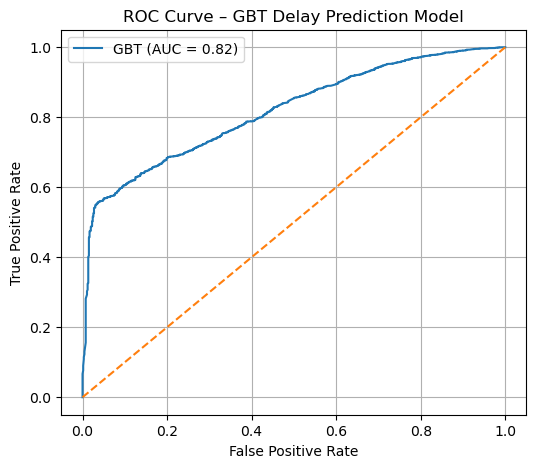

In [ ]:


# Convert required columns to pandas
roc_pd = (
    gbt_pred
    .select("is_delayed", "probability")
    .toPandas()
)

# Extract probability of positive class (delay = 1)
roc_pd["prob_delay"] = roc_pd["probability"].apply(lambda x: float(x[1]))

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(roc_pd["is_delayed"], roc_pd["prob_delay"])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"GBT (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – GBT Delay Prediction Model")
plt.legend()
plt.grid(True)
plt.show()


# MODEL INSIGHTS & VISUAL ANALYSIS 
These visuals support:
- **Predict timetable delays / non-compliance**
- **Detect disruption / congestion patterns**
- **Forecast peak travel hours**


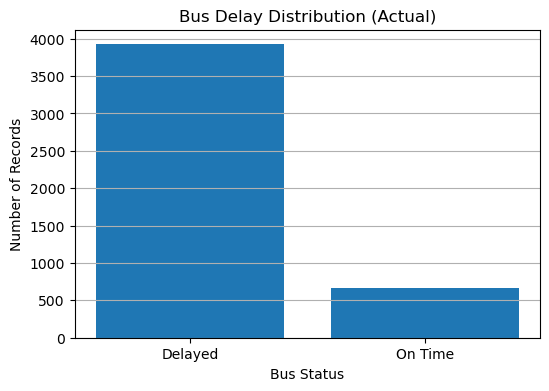

In [ ]:
delay_counts = (
    gbt_pred
    .groupBy("is_delayed")
    .count()
    .toPandas()
)

delay_counts["Status"] = delay_counts["is_delayed"].map({0: "On Time", 1: "Delayed"})

plt.figure(figsize=(6,4))
plt.bar(delay_counts["Status"], delay_counts["count"])
plt.title("Bus Delay Distribution (Actual)")
plt.xlabel("Bus Status")
plt.ylabel("Number of Records")
plt.grid(axis="y")
plt.show()

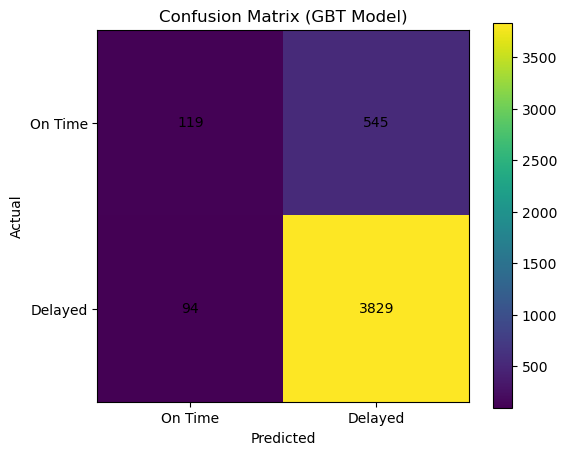

In [ ]:
cm = (
    gbt_pred
    .groupBy("is_delayed", "prediction")
    .count()
    .toPandas()
)

pivot_cm = cm.pivot(index="is_delayed", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(6,5))
plt.imshow(pivot_cm, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix (GBT Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["On Time", "Delayed"])
plt.yticks([0,1], ["On Time", "Delayed"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, int(pivot_cm.iloc[i, j]), ha="center", va="center")

plt.show()

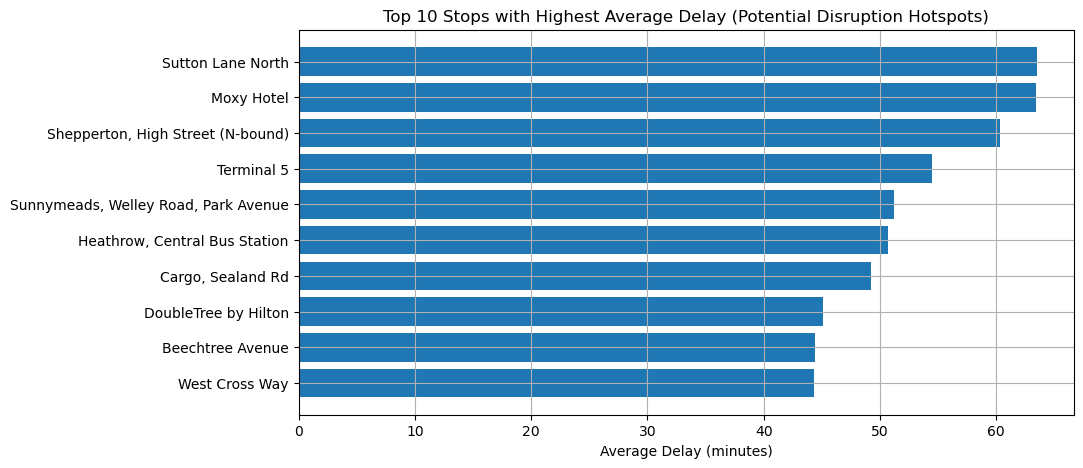

In [ ]:
stop_delay = (
    gbt_pred
    .groupBy("stop_name")
    .avg("delay_minutes")
    .orderBy(col("avg(delay_minutes)").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,5))
plt.barh(stop_delay["stop_name"], stop_delay["avg(delay_minutes)"])
plt.title("Top 10 Stops with Highest Average Delay (Potential Disruption Hotspots)")
plt.xlabel("Average Delay (minutes)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

## STEP 9: Save Predictions (optional)

In [ ]:
import os
from pyspark.sql.functions import col

print("\n" + "="*80)
print("STEP 9: SAVING PREDICTIONS SAFELY")
print("="*80)

# -------- Safe output location (Desktop) --------
OUTPUT_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "bus_predictions_output")
OUTPUT_FILE = os.path.join(os.path.expanduser("~"), "Desktop", "bus_predictions.csv")

# -------- Select only existing columns --------
out_cols = [
    "RecordedAtTime_ts", "delay_minutes", "is_delayed", "prediction",
    "line_ref", "operator_ref", "stop_id", "stop_name", "distance_m"
]
available_cols = [c for c in out_cols if c in gbt_pred.columns]

df_out = gbt_pred.select(*available_cols)

# -------- Cast timestamp to string (Spark-safe) --------
if "RecordedAtTime_ts" in df_out.columns:
    df_out = df_out.withColumn("RecordedAtTime_ts", col("RecordedAtTime_ts").cast("string"))

# -------- Try Spark write first --------
try:
    (
        df_out
        .coalesce(1)
        .write
        .mode("overwrite")
        .option("header", "true")
        .csv(OUTPUT_DIR)
    )
    print(f"✅ Spark CSV saved successfully to:\n{OUTPUT_DIR}")
    print("➡️ Open folder and use the part-0000*.csv file")

# -------- Fallback to pandas if Spark fails --------
except Exception as e:
    print("⚠️ Spark write failed, falling back to pandas...")
    print("Reason:", str(e))

    pdf = df_out.toPandas()
    pdf.to_csv(OUTPUT_FILE, index=False)

    print(f" Pandas CSV saved successfully to:\n{OUTPUT_FILE}")



STEP 9: SAVING PREDICTIONS SAFELY
⚠️ Spark write failed, falling back to pandas...
Reason: An error occurred while calling o1708.csv.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapre